In [1]:
from my_transformer import MyTransformer
import pandas as pd
import numpy as np

# label
label_feature = 'Danceability'

# features
dont_transform_features = ['Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence']
normal_transform_features = ['Tempo']
power_transform_features = ['Loudness', 'Duration_ms', 'Stream', 'Views', 'Likes', 'Comments']
categorical_features = ['Album_type', 'Key', 'Licensed', 'official_video']
numerical_features=dont_transform_features + normal_transform_features + power_transform_features

# all features
features_columns = dont_transform_features + normal_transform_features + power_transform_features + categorical_features
label_column = label_feature

# import data
train_df = pd.read_csv('data/train.csv')[features_columns + [label_column]]
test_df = pd.read_csv('data/test.csv')[features_columns]
test_ids = pd.read_csv('data/test.csv')['id']

# init transformer
my_transformer = MyTransformer(
    all_features=features_columns,
    categorical_features=categorical_features,
    normal_transform_features=normal_transform_features,
    power_transform_features=power_transform_features,
    numerical_features=dont_transform_features + normal_transform_features + power_transform_features,
    label_column=label_column,
)

# transform dataset
train_X_df = my_transformer.features_fit_transform(train_df)
train_Y_df = my_transformer.label_fit_transform(train_df)
test_X_df = my_transformer.features_transform(test_df)

# to numpy
train_X = train_X_df.to_numpy()
train_Y = train_Y_df.to_numpy()
test_X = test_X_df.to_numpy()

feature_size = train_X.shape[1]
output_size = 1

# Model

In [47]:
hidden_sizes = [128, 64, 32, 16]
epoch = 500
batch_size = 128
lr=0.00007
validation_ratio = 0.2
patience=20

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping


# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(train_X, dtype=torch.float32)
y_train_tensor = torch.tensor(train_Y, dtype=torch.float32)

# Create TensorDatasets for training and validation
train_ds = TensorDataset(X_train_tensor, y_train_tensor)

# Calculate the sizes of the train and validation datasets based on the split ratio
train_size = int((1 - validation_ratio) * len(train_ds))
val_size = len(train_ds) - train_size

# Perform the random split
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

class DeepLinearModel(pl.LightningModule):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DeepLinearModel, self).__init__()
        self.save_hyperparameters()
        self.layers = nn.Sequential()
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            self.layers.add_module(f"linear_{i}", nn.Linear(sizes[i], sizes[i+1]))
            if i < len(sizes) - 2:
                self.layers.add_module(f"relu_{i}", nn.ReLU())

    def forward(self, x):
        x = self.layers(x)
        return x

    def training_step(self, batch, batch_idx, optimizer_idx=None):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.l1_loss(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, on_step=False)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = nn.functional.l1_loss(y_hat, y)
        self.log("val_loss", val_loss, prog_bar=False)
        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10)
        return [optimizer], [scheduler]

# Define the ModelCheckpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(monitor='val_loss')

# Define the EarlyStopping callback
early_stop_callback = EarlyStopping(monitor='val_loss', patience=patience, mode='min')

# Create a PyTorch Lightning Trainer
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(max_epochs=epoch, callbacks=[lr_monitor, checkpoint_callback, early_stop_callback])

# Create DataLoaders for training and validation
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize the model
model = DeepLinearModel(input_size=feature_size, hidden_sizes=hidden_sizes, output_size=output_size)

# Train the model using PyTorch Lightning
trainer.fit(model, train_dl, val_dl)


In [71]:
# Access the best model based on the validation loss
best_model = trainer.checkpoint_callback.best_model_path

best_model = DeepLinearModel.load_from_checkpoint(best_model)

def calculate_training_loss(best_model, ds, batch_size, my_transformer):
    # Set the best model to evaluation mode
    best_model.eval()

    # Create a DataLoader for the training dataset
    train_dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    # Calculate the training loss using the best model
    train_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in train_dl:
            x, y = batch
            x, y = x.to("mps"), y.to("mps")
            y_hat = best_model(x)
            y_hat, y = y_hat.cpu(), y.cpu()
            # Convert to numpy
            y_hat, y = y_hat.numpy(), y.numpy()
            y_hat, y = my_transformer.inverse_label_transform(y_hat.reshape(-1)), my_transformer.inverse_label_transform(y.reshape(-1))
            y_hat = np.clip(np.round(y_hat), 0, 9)
            loss = nn.functional.l1_loss(torch.tensor([y_hat]), torch.tensor([y]))
            train_loss += loss.item()
            num_batches += 1
            break

    train_loss /= num_batches

    return train_loss

train_loss = calculate_training_loss(best_model, train_ds, batch_size, my_transformer)
print("Training Loss:", train_loss)
train_loss = calculate_training_loss(best_model, val_ds, batch_size, my_transformer)
print("validation Loss:", train_loss)


Training Loss: 1.8281250335858203
validation Loss: 1.7265625384752639


In [72]:
x_test_tensor = torch.tensor(test_X, dtype=torch.float32)
ids = torch.tensor(test_ids, dtype=torch.int32)

test_ds = TensorDataset(ids, x_test_tensor)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

ids, preds = [], []
best_model.eval()
with torch.no_grad():
    for batch in test_dl:
        i, x = batch
        ids.append(i.numpy())
        
        y_hat = best_model(x.to("mps")).cpu().numpy()
        y_hat = my_transformer.inverse_label_transform(y_hat.reshape(-1))
        y_hat = np.clip(np.round(y_hat), 0, 9)
        preds.append(y_hat)

ids = np.concatenate(ids)
preds = np.concatenate(preds)

submission_df = pd.DataFrame({'id': ids, 'Danceability': preds})
submission_df.to_csv('submission.csv', index=False)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+0

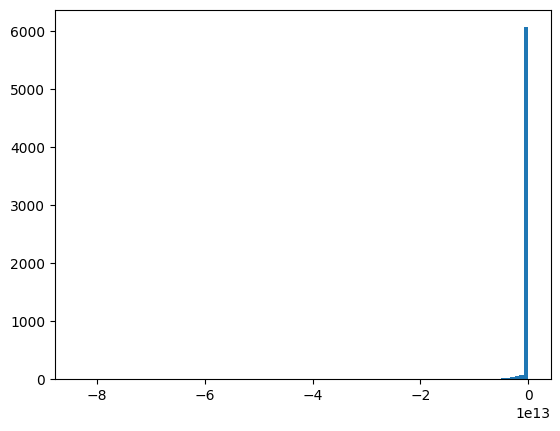

In [93]:
x_test_tensor = torch.tensor(test_X, dtype=torch.float32)
ids = torch.tensor(test_ids, dtype=torch.int32)

best_model.eval()
with torch.no_grad():
    preds = best_model(x_test_tensor.to("mps")).cpu().numpy()
# preds = my_transformer.inverse_label_transform(preds.reshape(-1))

import matplotlib.pyplot as plt

plt.hist(preds, bins=100)